# Tarea 2
## Laboratorio de Datos

In [1]:
# librerías usadas
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# 1 Carga y transformación de Datos

In [2]:
# 1
# iniciar datos
def load(path):
    image_rgb =Image.open(path).convert("RGB")
    return image_rgb

div= np.iinfo('uint8').max # maximo valor de tipo uint8
transformers=transforms.Compose(
                [transforms.Resize([224,224]),
                 transforms.RandomRotation(degrees=20),
                 transforms.RandomHorizontalFlip(),
                 transforms.ColorJitter(brightness=[1.2, 1.5]),
                 transforms.ToTensor()
                ])

# Usamos el loader por defecto de ImageFolder
# Deja las imagenes con 3 capas
from torchvision.datasets.folder import default_loader
    
data_train1=datasets.DatasetFolder(root='chest_xray/train',loader=default_loader,transform=transformers, extensions='jpeg')
data_test1=datasets.DatasetFolder(root='chest_xray/test',loader=default_loader,transform=transformers, extensions='jpeg')

In [ ]:
"""
To Do : 

Perfilamiento de tiempo de cómputo 

Comparación de las librerias pytorch PIL skimage opencv

"""

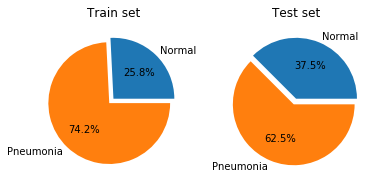

In [3]:
# 2

classes_train1 = data_train1.targets
classes_test1 = data_test1.targets

pneumonia_train=int(sum(classes_train1))
normal_train=len(classes_train1)-pneumonia_train


pneumonia_test=int(sum(classes_test1))
normal_test=len(classes_test1)-pneumonia_test

labels = 'Normal', 'Pneumonia'
sizes_train = [normal_train, pneumonia_train]

sizes_test = [normal_test, pneumonia_test]

fig, axs = plt.subplots(1,2)
axs[0].pie(sizes_train,labels=labels,explode=(0,0.1),autopct='%1.1f%%')
axs[1].pie(sizes_test,labels=labels,explode =(0,0.1),autopct='%1.1f%%')

axs[0].set_title('Train set')
axs[1].set_title('Test set')

plt.show()

In [4]:
# 3

from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

# split
train_idx, val_idx = train_test_split(list(range(len(data_train1))),test_size=0.2)
#data_train = Subset(data_train1, train_idx)
#data_val   = Subset(data_train1,val_idx)

class ReplicarMuestreoDePrueba(torch.utils.data.Sampler):
    
    def __init__(self,etiquetas_prueba, indices_val, etiquetas_val):
        self.indices_val      = indices_val
        #self.etiquetas_val    = etiquetas_val
        self.prob_pneumonia   = sum(etiquetas_val)/len(etiquetas_prueba)
        self.prob_normal      = 1-self.prob_pneumonia
        self.prob_vector      = [ int((etiquetas_val[i]==1 )*self.prob_pneumonia+
                                 (etiquetas_val[i]==0)*self.prob_normal)
                                for i in range(len(etiquetas_prueba))
                                ]
    def __iter__(self):
        return iter(np.random.choice(self.indices_val,p=self.prob_vector))
    
etiquetas_prueba = data_test1.targets
# indices_val = val_idx
etiquetas_val = [data_train1.targets[i] for i in val_idx ] 

a=ReplicarMuestreoDePrueba(etiquetas_prueba,val_idx, etiquetas_val)

In [5]:
# 4
from torch.utils.data.sampler import RandomSampler, SubsetRandomSampler

data_train = DataLoader(data_train1,sampler=SubsetRandomSampler(train_idx))
data_val   = DataLoader(data_train1,sampler=ReplicarMuestreoDePrueba(etiquetas_prueba,val_idx, etiquetas_val))
data_test  = DataLoader(data_test1,sampler=RandomSampler(data_test1))

In [9]:
data_train.dataset.

<function torchvision.datasets.folder.default_loader(path)>

In [7]:
len(train_idx)

4185